# Cálculo do R_t
---


- Notebook adaptado de: https://github.com/loft-br/realtime_r0_brazil/blob/master/realtime_r0_bettencourt_ribeiro.ipynb

- Modelo de [Kevin Systrom](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) baseado em: 
  - *Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases*. Bettencourt LMA, Ribeiro RM (2008) Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases. PLOS ONE 3(5): e2185. https://doi.org/10.1371/journal.pone.0002185

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import data</a></span></li><li><span><a href="#Deaths-in-states-heatmap" data-toc-modified-id="Deaths-in-states-heatmap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Deaths in states heatmap</a></span></li><li><span><a href="#Import-model" data-toc-modified-id="Import-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import model</a></span></li><li><span><a href="#Run-state-model" data-toc-modified-id="Run-state-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run state model</a></span><ul class="toc-item"><li><span><a href="#Plotting-states" data-toc-modified-id="Plotting-states-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plotting states</a></span></li><li><span><a href="#Compare-current-estimates" data-toc-modified-id="Compare-current-estimates-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Compare current estimates</a></span></li></ul></li><li><span><a href="#TODO:-Avg-estimation-w/-new-deaths-(From-ActNow)" data-toc-modified-id="TODO:-Avg-estimation-w/-new-deaths-(From-ActNow)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TODO: Avg estimation w/ new deaths (From ActNow)</a></span></li><li><span><a href="#Single-state-plot:-Customize" data-toc-modified-id="Single-state-plot:-Customize-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Single state plot: Customize</a></span></li><li><span><a href="#Draft" data-toc-modified-id="Draft-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Draft</a></span></li></ul></div>

## Import packages

In [111]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')
""
# Plotting
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Centering and fixing title
def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Adding custom colorscales (to add one: themes/custom_colorscales.yaml)\n",
import yaml
custom_colorscales = yaml.load(open('themes/custom_colorscales.yaml', 'r'))
cf.colors._custom_scales['qual'].update(custom_colorscales)
cf.colors.reset_scales()

# Setting cuffilinks template (use it with .iplot(theme='custom')
cf.themes.THEMES['custom'] = yaml.load(open('themes/cufflinks_template.yaml', 'r'))

# Adding custom colorscales (to add one: themes/custom_colorscales.yaml)
import yaml

In [112]:
import requests
from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed

# número de cores para paralelizar modelo nos estados
N_JOBS = -1

In [113]:
from src.loader.utils import get_config

config = get_config("https://raw.githubusercontent.com/ImpulsoGov/simulacovid/master/src/configs/config.yaml")

## Import data

In [114]:
from src.loader import get_cases

df = get_cases.now('br',
                   config,
                   last=False)

In [115]:
df.head()

,city,city_id,last_updated,epidemiological_week,estimated_population_2019,is_last,is_repeated,confirmed_cases,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,deaths,order_for_place,place_type,state,daily_cases,new_deaths,infectious_period_cases,state_notification_rate,notification_rate,active_cases
0,São Paulo,3550308,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1,0,1.0,NaN,NaN,NaN
1,São Paulo,3550308,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0,0,2,city,SP,0,0,1.0,NaN,NaN,NaN
2,São Paulo,3550308,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0,0,3,city,SP,0,0,1.0,NaN,NaN,NaN
3,São Paulo,3550308,2020-02-28,9,12252023.0,False,False,2,0.01632,2020-02-28,0.0,0,4,city,SP,1,0,2.0,NaN,NaN,NaN
4,São Paulo,3550308,2020-02-29,9,12252023.0,False,False,2,0.01632,2020-02-29,0.0,0,5,city,SP,0,0,2.0,NaN,NaN,NaN


<div class="alert alert-warning">
    
<b>A lot of cities have errors in confirmed cases (i.e. today is less than ystrd report!)</b>. When this happens, we take ysrtd value for today.
    
</div>

In [116]:
col = 'confirmed_cases'

In [117]:
df = df.rename({'last_updated': 'date'}, axis=1)

In [118]:
df[col+'_ystrd'] = df.sort_values(['city_id','date'])\
                                .groupby('city_id')[col]\
                                .shift(1).fillna(0)

df['is_reliable'] = np.where(df[col+'_ystrd'] <= df[col], True, False)
df['is_reliable'].value_counts()

True     59230
False      811
Name: is_reliable, dtype: int64

In [119]:
df[df['is_reliable'] == False]['city_id'].value_counts() # it occurs on last than 5 days in each city

3144805    6
3508504    5
3126109    4
4208500    4
3552403    4
          ..
4200606    1
5208707    1
1504901    1
3549904    1
3550209    1
Name: city_id, Length: 607, dtype: int64

In [120]:
df[df['city_id'] == 3144805].set_index('date')[col]\
                            .iplot(theme='custom', title='{} by day (city_id = 3144805)'.format(col))

* Correcting new daily cases: taking the max confimed cases until day each day

In [121]:
df[col+'_corrected'] = df.groupby('city_id').cummax()[col]

In [122]:
df[df['city_id'] == 3144805].set_index('date')[col+'_corrected']\
                            .iplot(theme='custom', title='corrected {} by day (city_id = 3144805)'.format(col))

In [123]:
df['daily_cases_corrected'] = df.groupby('city_id')[col+'_corrected'].diff(1)

# Adjust 1st day to confirmed cases
df['daily_cases_corrected'] = np.where(df['daily_cases_corrected'].isnull() == True, 
                                       df[col], 
                                       df['daily_cases_corrected'])

In [124]:
len(df[df['daily_cases_corrected'] < 0]) # just checking

0

* Adjusting new daily cases w/ estimated notification rate

In [125]:
df['adjusted_daily_cases'] = df['daily_cases_corrected'].fillna(0) / df['notification_rate']

* Filter city and state new cases

In [126]:
city_df = df[~df['adjusted_daily_cases'].isnull()][['city_id', 
                                                    'date', 
                                                    'adjusted_daily_cases']]\
            .rename({'city_id': 'city'}, axis=1)\
            .groupby(['city', 'date'])['adjusted_daily_cases']\
            .sum().round(0)

city_df.name = 'confirmed_new'

In [127]:
city_df

city     date      
1100015  2020-05-02      1.0
         2020-05-03      0.0
         2020-05-04      0.0
         2020-05-05      0.0
         2020-05-06      0.0
                       ...  
5300108  2020-05-04     58.0
         2020-05-05     39.0
         2020-05-06    190.0
         2020-05-07    185.0
         2020-05-08      0.0
Name: confirmed_new, Length: 56062, dtype: float64

In [128]:
state_df = df[~df['adjusted_daily_cases'].isnull()][['state', 'date', 'adjusted_daily_cases']]\
            .groupby(['state', 'date'])['adjusted_daily_cases']\
            .sum().round(0)

state_df.name = 'confirmed_new'

In [129]:
state_df

state  date      
AC     2020-04-12     8.0
       2020-04-13    24.0
       2020-04-14    16.0
       2020-04-15     4.0
       2020-04-16    26.0
                     ... 
TO     2020-05-04    39.0
       2020-05-05    73.0
       2020-05-06    87.0
       2020-05-07    88.0
       2020-05-08     0.0
Name: confirmed_new, Length: 941, dtype: float64

## Import model

> Vamos reproduzir o modelo do Kevin Systrom, baseado no artigo de Bettencourt & Ribeiro, para estimarmos $R_t$, o número de reprodução eficaz, para os estados brasileiros.
> 
> **Ajuste do modelo**
>
> Ajustamos um modelo bayesiano simples, assumindo que os dados de novos casos assumem uma distribuição Poisson parametrizada por $\lambda$ e a seguinte fórmula para a conexão entre $R_t$ e $\lambda$ (segundo este artigo):
>
> $$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$
>
> onde $\gamma$ é a recíproca do serial interval (em torno de 7 dias para o COVID19) e $k_{t-1}$ é o número de novos casos para o dia anterior. Abaixo rodamos a função run_full_model para todos os estados em paralelo. Mais detalhes no notebook do Kevin.

In [40]:
# model_url = 'https://raw.githubusercontent.com/loft-br/realtime_r0_brazil/master/core.py'
# # model_entrypoint = ''
# open('loft_model.py', 'w').write(requests.get(model_url).text)
# from loft_model import run_full_model, plot_rt, plot_standings

* Add parameters choice w/ [CovidActNow](https://github.com/covid-projections/covid-data-model/blob/089e4e81db32befd6e86e4e105454629fd834ad2/pyseir/inference/infer_rt.py) implementation and [Loft-BR](https://github.com/loft-br/realtime_r0_brazil/blob/master/core.py)

In [109]:
from model import run_full_model, plot_rt, plot_standings

## Run state model

* Loft params

In [142]:
with Parallel(n_jobs=1) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], source='LOFT') 
                       for grp in state_df.groupby(level='state'))

loft_results = pd.concat(results)

In [143]:
loft_results.reset_index().state.unique()

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [144]:
cases_cols = [
    'adjusted_daily_cases', 
    'daily_cases_corrected', 
    'confirmed_cases_corrected',
]

df_state_cases = df[~df['adjusted_daily_cases'].isnull()]\
                    .groupby(['state', 'date'])[cases_cols]\
                    .sum()\
                    .round(0)\
                    .join(df.groupby(['state', 'date'])['state_notification_rate'].max())

df_state_cases.head()

adjusted_daily_cases  daily_cases_corrected  \
state date                                                      
AC    2020-04-12                   8.0                    5.0   
      2020-04-13                  24.0                   13.0   
      2020-04-14                  16.0                    9.0   
      2020-04-15                   4.0                    2.0   
      2020-04-16                  26.0                   14.0   

                  confirmed_cases_corrected  state_notification_rate  
state date                                                            
AC    2020-04-12                         77                 0.698571  
      2020-04-13                         90                 0.641429  
      2020-04-14                         99                 0.664286  
      2020-04-15                        101                 0.653571  
      2020-04-16                        115                 0.630714

In [145]:
loft_results = loft_results.join(df_state_cases).reset_index()
loft_results

,state,date,Rt_most_likely,Rt_low_90,Rt_high_90,adjusted_daily_cases,daily_cases_corrected,confirmed_cases_corrected,state_notification_rate
0,AC,2020-04-12,3.00,0.86,6.84,8.0,5.0,77,0.698571
1,AC,2020-04-13,2.45,0.93,4.45,24.0,13.0,90,0.641429
2,AC,2020-04-14,2.34,0.99,3.94,16.0,9.0,99,0.664286
3,AC,2020-04-15,2.24,1.00,3.59,4.0,2.0,101,0.653571
4,AC,2020-04-16,2.23,1.06,3.41,26.0,14.0,115,0.630714
5,AC,2020-04-17,2.19,1.11,3.25,39.0,20.0,135,0.607857
6,AC,2020-04-18,2.19,1.17,3.14,14.0,7.0,142,0.572619
7,AC,2020-04-19,2.13,1.21,3.01,42.0,21.0,163,0.540238
8,AC,2020-04-20,2.03,1.17,2.83,28.0,13.0,176,0.517381
9,AC,2020-04-21,1.90,1.09,2.63,42.0,19.0,195,0.492738


In [146]:
loft_results.to_csv('br_states_estimated_rt.csv')

In [147]:
# import datetime as dt
# loft_results = loft_results[loft_results['date'] > dt.datetime.today() - dt.timedelta(days=30)]

* Act Now params

In [148]:
# with Parallel(n_jobs=1) as parallel:
#     results = parallel(delayed(run_full_model)(grp[1], source='ACT_NOW') 
#                        for grp in state_df.groupby(level='state'))

# actnow_results = pd.concat(results)

In [149]:
# actnow_results.reset_index().state.unique()

### Plotting states

In [150]:
def plot_rt_states(final_results):

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

In [151]:
# plot_rt_states(actnow_results)

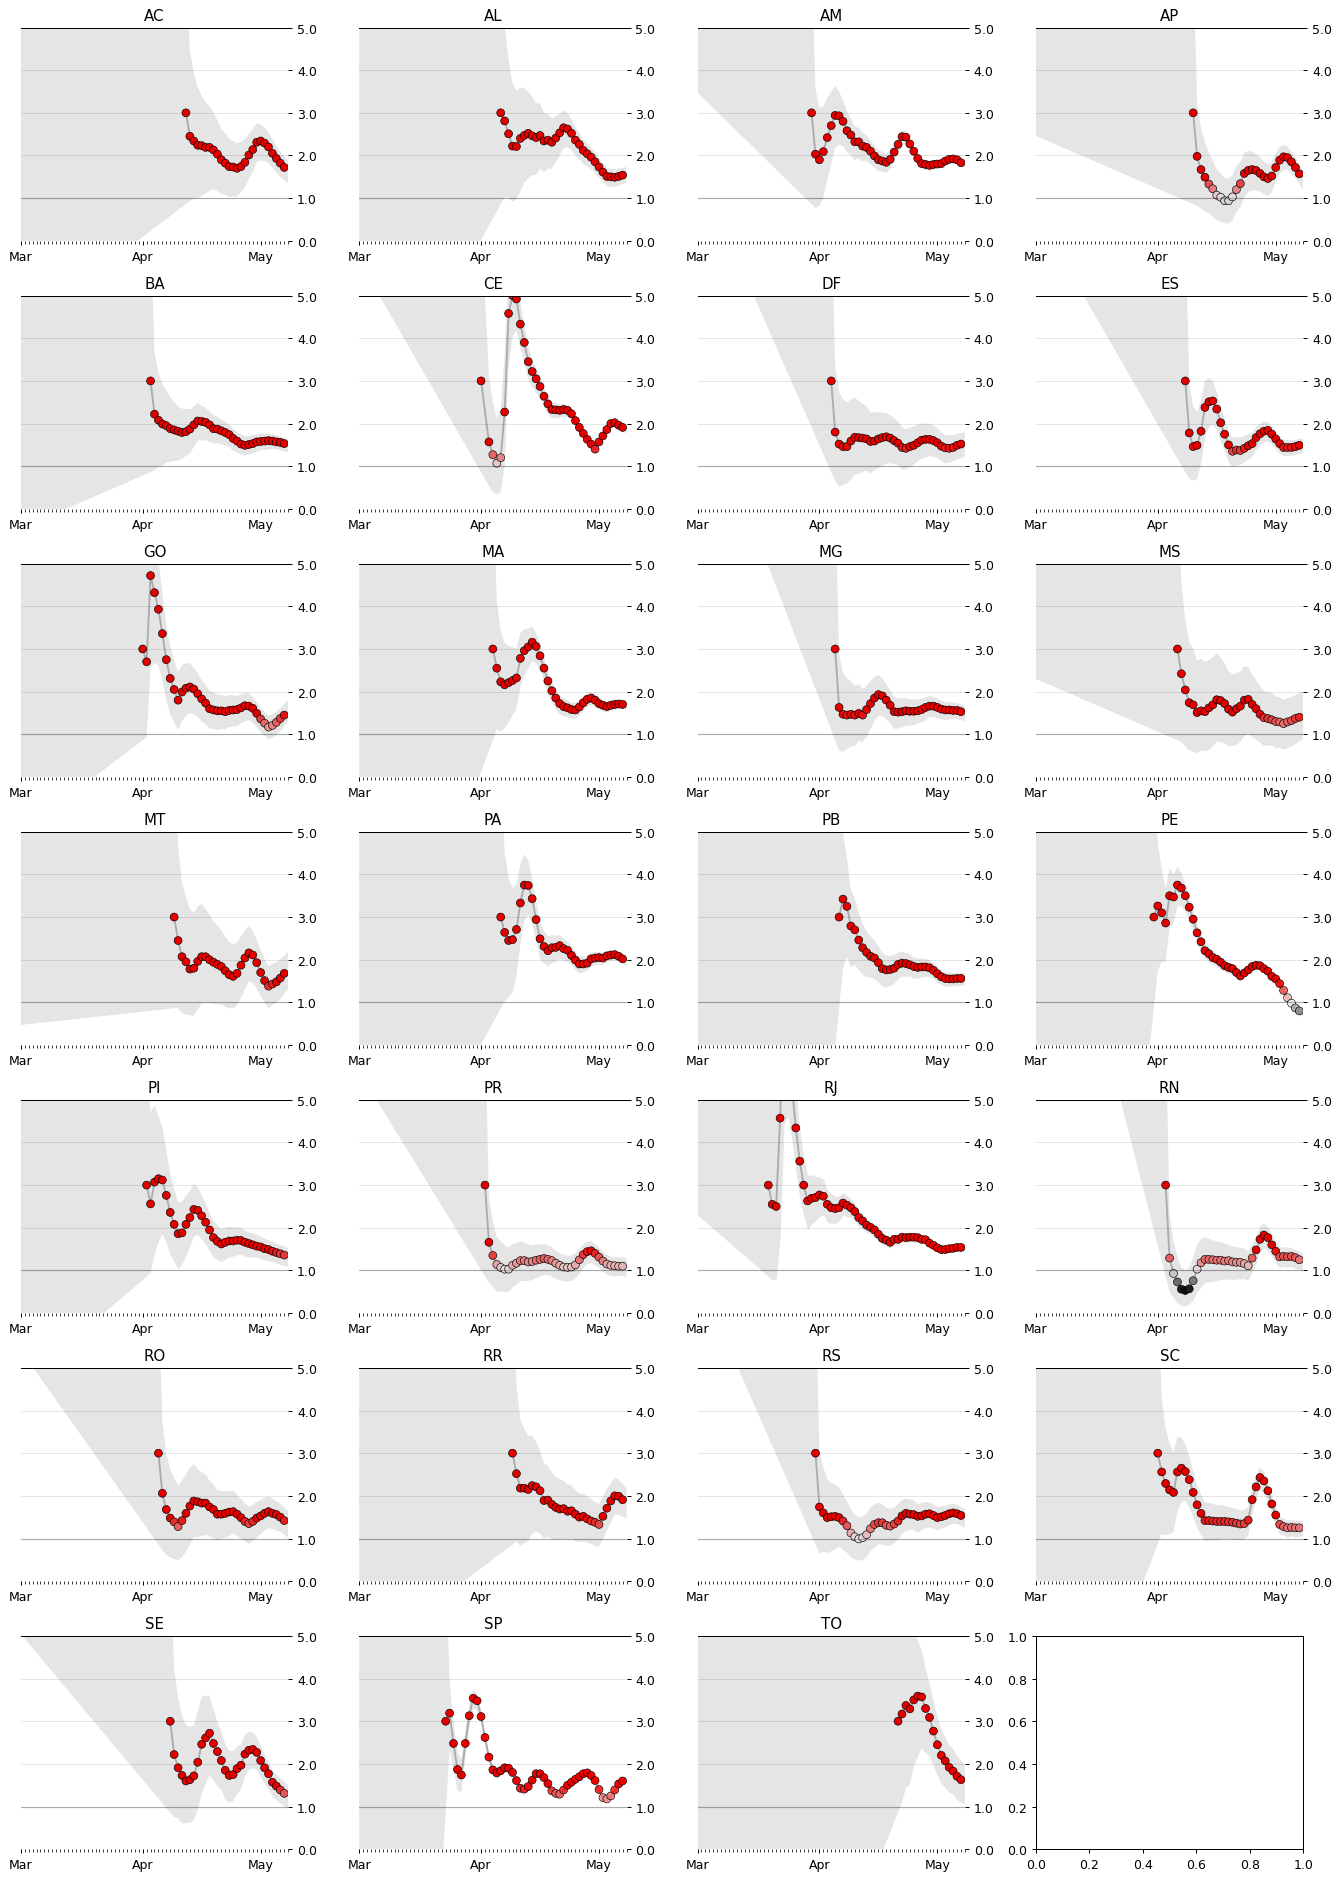

In [152]:
plot_rt_states(loft_results.set_index(['date', 'state']))

### Compare current estimates

In [88]:
# max_date = state_df.reset_index()['date'].max()
# max_date

In [87]:
# t = actnow_results.reset_index()[actnow_results.reset_index()['date'] == max_date].merge(loft_results.reset_index()[loft_results.reset_index()['date'] == max_date],
#                                                                                     on=['state', 'date'], suffixes=['_act', '_loft'])

# t

## TODO: Avg estimation w/ new deaths (From ActNow)

- They add Rt estimation w/ `new_deaths` and `new_hospitalizations`, shifting the dates for best approx w/ the series generated using `new_cases` and getting the mean value for each day

In [136]:
from scipy import signal

def align_time_series(series_a, series_b):
    """
    Identify the optimal time shift between two data series based on
    maximal cross-correlation of their derivatives.
    Parameters
    ----------
    series_a: pd.Series
        Reference series to cross-correlate against.
    series_b: pd.Series
        Reference series to shift and cross-correlate against.
    Returns
    -------
    shift: int
        A shift period applied to series b that aligns to series a
    """
    shifts = range(-21, 5)
    valid_shifts = []
    xcor = []
    np.random.seed(42)  # Xcor has some stochastic FFT elements.
    _series_a = np.diff(series_a)

    for i in shifts:
        series_b_shifted = np.diff(series_b.shift(i))
        valid = (~np.isnan(_series_a) & ~np.isnan(series_b_shifted))
        
        if len(series_b_shifted[valid]) > 0:
            xcor.append(signal.correlate(_series_a[valid], series_b_shifted[valid]).mean())
            valid_shifts.append(i)
            
    if len(valid_shifts) > 0:
        return valid_shifts[np.argmax(xcor)]
    
    else:
        return 0

## Single state plot: Customize

In [145]:
# Adding custom colorscales (to add one: themes/custom_colorscales.yaml)\n",
import yaml
custom_colorscales = yaml.load(open('themes/custom_colorscales.yaml', 'r'))
cf.colors._custom_scales['qual'].update(custom_colorscales)
cf.colors.reset_scales()

# Setting cuffilinks template (use it with .iplot(theme='custom')
cf.themes.THEMES['custom'] = yaml.load(open('themes/cufflinks_template.yaml', 'r'))

In [185]:
df_uf = results[8]
#df_uf

In [186]:
t = df_uf.reset_index()#.set_index('date')
t['date'] = pd.to_datetime(t['date'])

t['group'] = np.where(t['ML'] >= 1.2, 'high', np.where(t['ML'] >= 1, 'medium', 'low'))
t['color'] = t['group'].map({'high': '#F26430', 
                             'medium':'#F2CD13', 
                             'low': '#435159'})

cols = {'ML': 'Rt estimado',
        'Low_90': 'min IC-90%',
        'High_90': 'max IC-90%',
        'group': 'group'}

t = t.rename(cols, axis=1)

In [189]:
fig = go.Figure()

error_color = '#E5E5E5'

fig.add_trace(
    go.Scatter(
        x=t['date'], 
        y=t['min IC-90%'], 
        mode='lines', 
        # fill='tonexty',
        line_color=error_color,
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t['date'], 
        y=t['max IC-90%'], 
        mode='lines', 
        fill='tonexty',
        line_color=error_color,
        name='IC-90%'
    )
)


fig.add_trace(
    go.Scatter(
        x=t['date'], 
        y=t['Rt estimado'], 
        mode='markers+lines',
        line_color='#898F8F',
        marker=dict(size=12,
                   color=t['color']),
        name='Rt estimado'
    )
)


fig.update_layout(yaml.load(open('themes/cufflinks_template.yaml', 'r'))['layout'])
fig.update_layout({'title': 'Número de reprodução básico COVID-19 - {}'.format(t['state'].unique()[0])})

## Draft

In [19]:
# lendo do repositório do Wesley Cota
city_df, state_df = load_data()

In [20]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50201 entries, ('Abaetetuba/PA', Timestamp('2020-03-31 00:00:00')) to ('Óbidos/PA', Timestamp('2020-05-04 00:00:00'))
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   deaths_new                       50201 non-null  int64  
 1   deaths_total                     50201 non-null  int64  
 2   confirmed_new                    50201 non-null  int64  
 3   confirmed_total                  50201 non-null  int64  
 4   deaths_per_100k_inhabitants      50201 non-null  float64
 5   totalCases_per_100k_inhabitants  50201 non-null  float64
 6   deaths_by_totalCases             50201 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.8+ MB


In [21]:
city_df[city_df['deaths_total'] > 100]

deaths_new  deaths_total  confirmed_new  \
city         date                                                  
Belém/PA     2020-04-30          50           139            171   
             2020-05-01          17           156            134   
             2020-05-02          22           178            188   
             2020-05-03           2           180             42   
             2020-05-04           0           180              0   
...                             ...           ...            ...   
São Paulo/SP 2020-04-30          83          1522           1511   
             2020-05-01          85          1607            938   
             2020-05-02          54          1661            407   
             2020-05-03          12          1673            328   
             2020-05-04           0          1673              0   

                         confirmed_total  deaths_per_100k_inhabitants  \
city         date                                                       
Belém/PA     2020-04-30             1658                      9.31170   
             2020-05-01             1792                     10.45055   
             2020-05-02             1980                     11.92434   
             2020-05-03             2022                     12.05832   
             2020-05-04             2022                     12.05832   
...                                  ...                          ...   
São Paulo/SP 2020-04-30            18149                     12.42244   
             2020-05-01            19087                     13.11620   
             2020-05-02            19494                     13.55694   
             2020-05-03            19822                     13.65489   
             2020-05-04            19822                     13.65489   

                         totalCases_per_100k_inhabitants  deaths_by_totalCases  
city         date                                                               
Belém/PA     2020-04-30                        111.07054               0.08384  
             2020-05-01                        120.04730               0.08705  
             2020-05-02                        132.64154               0.08990  
             2020-05-03                        135.45515               0.08902  
             2020-05-04                        135.45515               0.08902  
...                                                  ...                   ...  
São Paulo/SP 2020-04-30                        148.13064               0.08386  
             2020-05-01                        155.78652               0.08419  
             2020-05-02                        159.10842               0.08521  
             2020-05-03                        161.78553               0.08440  
             2020-05-04                        161.78553               0.08440  

[162 rows x 7 columns]

In [23]:
s = (
    city_df.reset_index()[['deaths_total', 'city']]
    .query('city != "Brazil"').query('deaths_total > 0')
    .groupby(['city']).max()
    .sort_values(by='deaths_total', ascending=False)
    .cumsum()
    .reset_index(drop=True)
)

s = s.divide(s.max()) * 100
# s.iplot(
#           title='80% das mortes ocorreram em 79 municípios',
#           xTitle='# de Municípios',
#            yTitle='% das Mortes',
#            theme='white',
#            bins=100,
#             width=5,
#         dimensions=(500,500)
#           )

In [24]:
s

,deaths_total
0,22.886457
1,31.518468
2,38.741450
3,44.158687
4,47.811218
...,...
772,99.945280
773,99.958960
774,99.972640
775,99.986320


In [25]:
s = (
    city_df.reset_index()[['deaths_total', 'city']]
    .query('city != "Brazil"').query('deaths_total > 0')
    .groupby(['city']).max()
    .sort_values(by='deaths_total')
    .reset_index(drop=True)
)
deaths = s['deaths_total']
s['cities'] = s.index #/ s.index.max() * 100
s = s.sort_values(by='cities', ascending=False).drop('deaths_total', 1)
s.index = deaths
# s.iplot(
#           title='$$\\text{Uma linda curva que segue } x^{-\\beta}$$',
#           yTitle='# de Municípios com menos de X mortes',
#            xTitle='# de Mortes',
#            theme='white',
#            bins=100,
#         width=5,
#         xaxis_type="log", yaxis_type="log",
#         dimensions=(500,500)
#           )

In [26]:
sample = city_df.query('deaths_total > 20')['deaths_new']

In [27]:
sample.groupby(level='city').count()

city
Belém/PA                            18
Brasília/DF                         18
Brazil                              44
CASO SEM LOCALIZAÇÃO DEFINIDA/AM     1
CASO SEM LOCALIZAÇÃO DEFINIDA/PE     2
CASO SEM LOCALIZAÇÃO DEFINIDA/RJ     1
CASO SEM LOCALIZAÇÃO DEFINIDA/SP     4
Camaragibe/PE                        3
Campinas/SP                          2
Curitiba/PR                          4
Diadema/SP                           4
Duque de Caxias/RJ                  19
Fortaleza/CE                        30
Guarulhos/SP                        20
Jaboatão dos Guararapes/PE          14
João Pessoa/PB                      14
Macapá/AP                            7
Maceió/AL                            8
Manacapuru/AM                        7
Manaus/AM                           27
Mauá/SP                              4
Mogi das Cruzes/SP                   4
Niterói/RJ                           5
Nova Iguaçu/RJ                      11
Olinda/PE                           14
Osasco/SP           

In [35]:
with Parallel(n_jobs=1) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sample.groupby(level='city'))

final_results = pd.concat(results)

IndexError: index 0 is out of bounds for axis 0 with size 0

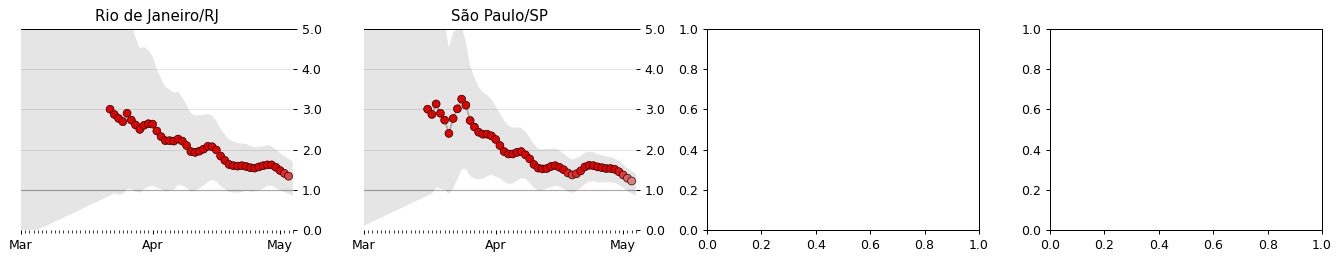

In [65]:
def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('city')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()